In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import matplotlib.pyplot as plt

In [258]:
from utils.fetch_data import fetch_timeseries_data
from utils.load_data import TimeSeriesDataset
import utils.train_model as train_mod
import importlib
importlib.reload(train_mod)
train_oned = train_mod.train_oned

In [13]:
import importlib
import utils.fetch_data as fetch_data
importlib.reload(fetch_data)
create_splits = fetch_data.create_splits
create_oned_chunks = fetch_data.create_oned_chunks

In [29]:
from utils.early_stopping import EarlyStopping

**Forecasting Several Timesteps ahead:**
- we have only predicted the value at the next timestep so far but we could just as easily have predicted the value several steps ahead by changing the targets appropriately (e.g. to predict the ridership 2 weeks from now, we could just change the targets to be the value 14 days ahead instead of 1 day ahead). 

- predicting the next 14 values: The first option is to take the univar_model RNN trained earlier for the rail timeseries, amke it predict the next value, add that value to the inputs, acting as if the predicted value had actually occurred; we would then use the model again to predict the following value and so on.....

Get the data:

In [3]:
df = fetch_timeseries_data()

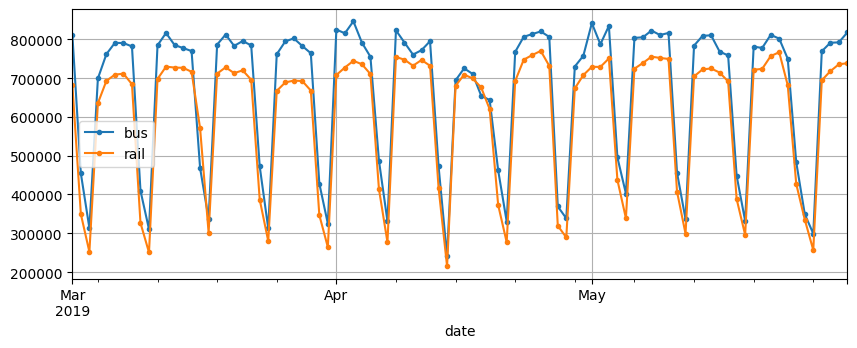

In [4]:
df['2019-03':'2019-05'].plot(grid=True, marker='.',figsize=(10,3.5))
plt.show()

Create the training, validation, and test sets:

<Axes: ylabel='Frequency'>

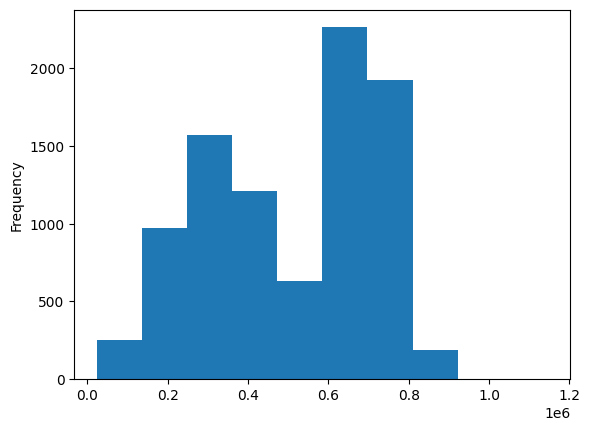

In [6]:
df['rail'].plot(kind='hist')

Most values are between 0 to 1 million: too large and we need to standardize these to ensure that gradient updates are stable.

In [19]:
torch.manual_seed(1)

In [20]:
rail_train, rail_valid, rail_test = create_splits(df)

In [21]:
rail_train_chunks, rail_valid_chunks, rail_test_chunks = create_oned_chunks(56,rail_train), create_oned_chunks(56,rail_valid), create_oned_chunks(56,rail_test)

In [22]:
rail_train_ds, rail_valid_ds, rail_test_ds = TimeSeriesDataset(torch.tensor(rail_train_chunks)), TimeSeriesDataset(torch.tensor(rail_valid_chunks)), TimeSeriesDataset(torch.tensor(rail_test_chunks))

In [23]:
len(rail_train_ds), len(rail_valid_ds), len(rail_test_ds)

(1040, 95, 2228)

In [24]:
rail_train_dl = DataLoader(rail_train_ds, batch_size=128, shuffle=True)
rail_valid_dl = DataLoader(rail_valid_ds, batch_size=128)
rail_test_dl = DataLoader(rail_test_ds, batch_size=1024)

Forecasting Using a simple rnn:

In [331]:
class UnivarModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, hn = self.rnn(x.unsqueeze(2))
        return self.linear(hn[-1, :, :])  

In [332]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")

In [333]:
torch.manual_seed(1)

In [334]:
univar_model = UnivarModel(1, 32).to(device)

In [335]:
#optimizer = torch.optim.SGD(univar_model.parameters(), lr=0.002, momentum=0.9, nesterov=True)
optimizer = torch.optim.Adam(univar_model.parameters(), lr=0.02)
criterion = nn.HuberLoss(reduction='sum')
early_stopper = EarlyStopping(patience=50, checkpoint_path = 'univar_model2.pt', restore_best_weights=True, verbose=True)
#cheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.009, epochs=500, steps_per_epoch=len(rail_train_dl))
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',patience=5)

In [336]:
t_loss, v_loss = train_oned(500, univar_model, rail_train_dl, rail_valid_dl, device, criterion, optimizer, early_stopper, performance_scheduler=scheduler,other_scheduler=None, l1_norm=True, l1_lambda=0.03e-5)

Epoch: 1| Train loss: 0.0496| Val loss: 0.0374
Metric improved to 0.0374. Checkpoint saved at epoch 0
Epoch: 2| Train loss: 0.0217| Val loss: 0.0247
Metric improved to 0.0247. Checkpoint saved at epoch 1
Epoch: 3| Train loss: 0.0135| Val loss: 0.0148
Metric improved to 0.0148. Checkpoint saved at epoch 2
Epoch: 4| Train loss: 0.0152| Val loss: 0.0126
Metric improved to 0.0126. Checkpoint saved at epoch 3
Epoch: 5| Train loss: 0.0120| Val loss: 0.0085
Metric improved to 0.0085. Checkpoint saved at epoch 4
Epoch: 6| Train loss: 0.0113| Val loss: 0.0161
No improvement for 1 epoch(s)
Epoch: 7| Train loss: 0.0195| Val loss: 0.0300
No improvement for 2 epoch(s)
Epoch: 8| Train loss: 0.0209| Val loss: 0.0162
No improvement for 3 epoch(s)
Epoch: 9| Train loss: 0.0728| Val loss: 0.0556
No improvement for 4 epoch(s)
Epoch: 10| Train loss: 0.0317| Val loss: 0.0338
No improvement for 5 epoch(s)
Epoch: 11| Train loss: 0.0211| Val loss: 0.0293
No improvement for 6 epoch(s)
Epoch: 12| Train loss: 0.0

In [337]:
l1_loss = nn.L1Loss(reduction='sum')

loss_ = []

with torch.no_grad():
    for x_test_batch, y_test_batch in rail_test_dl:
        x_test_batch = x_test_batch.to(device)
        y_test_batch = y_test_batch.to(device)
        hn = univar_model(x_test_batch)
        loss = l1_loss(hn.squeeze(1), y_test_batch)
        loss_.append(loss.item())

In [338]:
sum(loss_)/len(rail_test_dl.dataset)*1e6

84446.76407791767

**Forecasting Several timesteps ahead:**
- Using both the validation and test sets:
- rail_valid is from 2019-01 to 2019-05.

In [347]:
rail_valid[:58].values

array([0.245852, 0.573542, 0.627781, 0.628514, 0.348257, 0.260556,
       0.66247 , 0.701693, 0.685444, 0.690162, 0.679115, 0.325219,
       0.250222, 0.705571, 0.720095, 0.728048, 0.734929, 0.700006,
       0.312424, 0.236744, 0.401503, 0.712125, 0.718899, 0.7113  ,
       0.590674, 0.296063, 0.221081, 0.67881 , 0.579917, 0.097917,
       0.243912, 0.648091, 0.34565 , 0.250724, 0.718764, 0.734181,
       0.727769, 0.732351, 0.655823, 0.338847, 0.251192, 0.704667,
       0.698387, 0.728764, 0.746611, 0.687932, 0.362613, 0.256817,
       0.519409, 0.725195, 0.717172, 0.727504, 0.702988, 0.328179,
       0.240478, 0.680844, 0.699462, 0.711827])

In [366]:
pred_set = list(rail_valid[:58].values)

In [368]:
# using 93 cuz thats the difference between the chosen 58 values (first 58) and the rest of the series (valid set)
with torch.no_grad():
    for i in range(93):
        result = univar_model(torch.tensor(pred_set[-56:]).reshape(1,56).float().to(device))
        pred_set.append(result.detach().item())

In [369]:
len(pred_set)

151

In [370]:
pred_set_emb = pd.Series(pred_set, index=rail_valid.index)

<Axes: xlabel='date'>

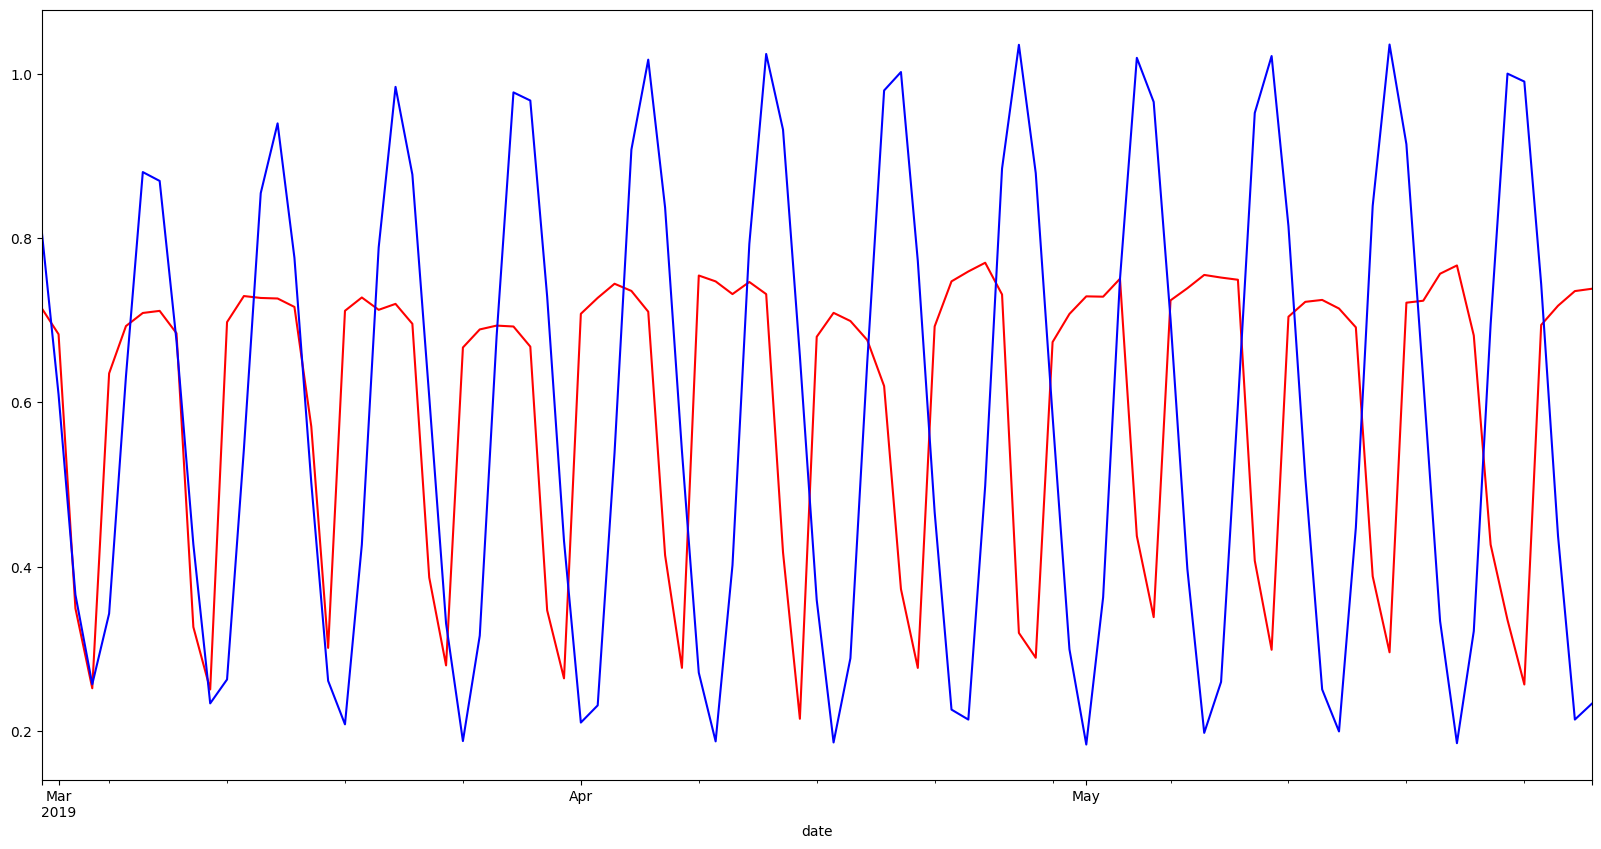

In [374]:
fig, ax = plt.subplots(figsize=(20,10))

rail_valid[58:].plot(ax=ax, color='red', label='truth')
pred_set_emb[58:].plot(ax=ax, color='blue',label='pred')

Above is prediction using predicted values to predict the next values